Данный блокнот содержит все имеющиеся на текущий момент сведения по работе над датасетом первых воспоминаний 'reminiscence'.

Вопросы исследования

Черновой план дальнейшей работы:
- В случае неизвестного возраста можно было бы указывать возраст с вопросом (когда в воспоминании есть ограничивающий маркер - умение ходить, говорить и т.д.)
- Было бы полезно подробнее рассказать о сборе воспоминаний - какие номера какому типу сбора соответствуют, где был их источник
- Можно разбивать воспоминания более подробно (одно воспоминание -- одна строка), и соединять для текстового представления по необходимости -- учитывая сколько символов приходится на один блок и воспоминание в целом
- Мысль: коррекция возраста - в случае, когда действие происходит в день рождения и известен возраст, то это конкретная точка
- Сформулировать чем могут быть полезны тексты с такой разбивкой для других примеров, как иначе использовать датасет
- Описать разделы построений распределений для каждой категории таблицы
- Отсортировать идеи из этого списка - по максимуму реализовать в виде разделов
- Проверка опечаток в записях -- какие существуют инструменты проверки орфографии из Python или Jupyter?
- Переделать "мама, папа" на "мать, отец" - в представлении данных
- Сравнить упоминания "мама, папа" и "родители"
- Отследить сущность "солнце", "солнечный свет", "искусственный свет", мотив света
- Построение распределения возрастов всех воспоминаний (не минимальных)
- Сколько предложений в среднем приходится на одно воспоминание?
- Инструмент для объектов вида "объект (общая группа объектов)"
- Было бы удобно, если бы исходный датафрейм был глобальной переменной
- Функция определения близости воспоминаний (NLP, ML)
- Преобразовать отображение чисел в возрастах к единообразному
- Инструмент для представления исходных данных и обработанных в верстке удобной для публикации в pdf (LaTeX), в виде статьи на Medium, в fb2, epub-форматах с заголовками и содержанием
- Сделать переводную версию
- Преобразование в pandas строковых значений чисел в числовые
- Инструмент перечисления номеров воспоминаний, в которых не заполнено переданное поле
- Распределения записей по числовым параметрам:
    - Возраст (общий инструмент для разных граф - с целью построения корреляций). Для пары "возраст-воспоминание" имеет смысл построить распределения самых ранних воспоминаний, если указан диапазон - то указывать среднюю точку с интервалом (необходимо найти подходящий тип визуализации)
    - Активное-пассивное
    - Доли воспоминаний с упоминанием параметра (цвет, ...)
    - Соотношение между полами
    - Наличие/отсутствие лиц и вообще инструмент заполненности поля (сколько символов "-" и сколько заполненных)
- Инструменты визуализации статистических распределений - лучшее представление
- pymorphy: частотное распределение слов, приведенных к нормальной форме, разбивать составные воспоминания по отступу в виде одной строки или специальному символу. Отношение между частями речи. Что преобладает в коротких воспоминаниях? Анализ по парам младший/старший, мама/пара, бабушка/дедушка.
- pymorhy:
    - Выделение в нормальной форме всех частей речи, построение распределений для каждой части речи по общему массиву
    - Выделение всех корней
- Сопоставление отец-папа, мама и папа-родители (совместность).
- Продумать процесс работы с ячейками перевода воспоминаний
- Функция генерации текста из чередующихся "малых" и "крупных" воспоминаний для облегчения чтения в виде текста

# Считывание данных из Google Sheet

Набор данных оформлен [в виде электронной таблицы на Google Drive](https://docs.google.com/spreadsheets/d/1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI/edit?usp=sharing). Доступ к Google Sheets API осуществляется в соответствии с [документацией API для Python](https://developers.google.com/sheets/api/quickstart/python).

Импортируем данные учетной записи и преобразуем в объект Pandas:

In [1]:
%matplotlib inline

import json
import os.path
import pickle       # для хранения токенов
import pandas as pd
import matplotlib
    
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SPREADSHEET_ID = '1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI' # id гугл-таблицы
RANGE_NAME = 'Memories' # Забираем лист целиком диапазон

In [2]:
def get_data():
    """Авторизует и забирает данные из Google SpreadSheet"""
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## Обработка данных в Pandas

Создаем датафрейм. Удаляем те строки, что не относятся к датасету (комментарии в конце файла)

In [3]:
def get_df():
    data = get_data()
    df = pd.DataFrame.from_records(data)
    headers = df.iloc[0]  # Названия столбцов содержатся в нулевой строке таблицы
    df = pd.DataFrame(df.values[1:], columns=headers)
    df = df.set_index('№') # Номер строки соответствует номеру воспоминания
    
    # Пока не рассматриваются переводные записи. Комментарии используются лишь как заметки
    df = df.drop(columns=['Name', 'Translation', 'Translation footnote', 'Комментарий'])
    
    # Добавим столбец подсчета числа символов, из которых состоит запись.
    df ['Число символов'] = df['Воспоминание'].apply(lambda x: len(x))
    
    return df

Для обзора датасета создадим функции подсчета числа пустых ячеек определенного поля, а также вывода необработанной части датасета в порядке возрастания объема записи.

In [31]:
def col_empty_cells(df, col_name:str):
    """Находит пустые и NoneType ячейки столбца с именем col_name"""
    none_cells = df[col_name][~df[col_name].notna()].index
    empty_cells = df[col_name][df[col_name]==''].index
    ids = sorted(list(set(none_cells) | set(empty_cells)))
    return ids

#! Откорректировать так, чтобы учитывались одиночные пустые ячейки
def percent_line():
    """Определяет долю полностью обработанных записей, не содержащие пустых строк во всех полях,
    за исключением графы Комментарий. Выводятся строки, в порядке возрастания объема воспоминания"""
    # отбираем записи, содержащие не более 1 пустой графы - обычно это графа комментарий 
    df = get_df()
    df_not_ready = df[df.apply(lambda x: x.isnull().sum(), axis='columns') > 0]
    p = 100*(1-len(df_not_ready)/len(df))
    print("Осталось обработать целиком записей: {0}, подготовлено {1:.1f}% датасета.".format(len(df_not_ready), p))
    return df_not_ready.sort_values(by='Число символов').head(10)

In [35]:
percent_line()

Осталось обработать целиком записей: 60, подготовлено 90.7% датасета.


,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
475,Майк (финн),,м,,3-4,None,None,None,None,None,None,None,None,None,None,None,None,None,0
353,Наташа,Мне было года три. Мы с мамой идём в гости к м...,ж,1,3,,,мама,None,None,None,None,None,None,None,None,None,None,276
350,Настя,"От года до полутора. Когда я, будучи взрослой,...",ж,1,,,,мама,None,None,None,None,None,None,None,None,None,None,277
263,Даша,День рождения. Мне исполняется три или четыре ...,ж,1,3-4,день рождения,"встреча дня рождения, вид со стороны",-,"барби (игрушка), машинка (игрушка)",-,собственный плач,-,-,-,-,не ночь,-,None,284
272,Катя,"Мне полгода. Октябрь 1984 года. В коляске, в н...",ж,1,0.5,,,мама,None,None,None,None,None,None,None,None,None,None,350
403,Аня,"Я помню, как лежу в воде на ткани, чувствую те...",ж,1,1-1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,355
262,Ира,Полтора года. Я с семьей на базе отдыха на озе...,ж,1,1.5,,,бабушка,None,None,None,None,None,None,None,None,None,None,367
328,Ксюша,"Санаторий, где мы были с мамой. Тётенька выста...",ж,2,1.25,подтверждение родителей,,"папа, мама",,,,,,,санаторий,None,None,None,377
371,Ваня,"Мы семьёй приехали куда-то на праздник, в дере...",м,2,-,-,,,,белый,None,None,None,None,None,None,None,None,379


# Функции предварительной обработки набора данных

In [17]:
df = get_df()

In [18]:
#! поиск дубликатов
print('Число дублирующихся записей в датасете: {}.'.format(len(df[df.duplicated()==True])))

Число дублирующихся записей в датасете: 0.


# Исследование распределений

Полностью заполнена лишь графа, содержащая текст воспоминания. Для указания того, что в тексте воспоминания не имеется дополнительной информации, указывает знак "-" (минус). Для анализа полноты используется функция `minus_or_smth_dstrb`.

In [27]:
def minus_or_smth(col_name: str):
    """Выводит число пустых ячеек, ячеек с символом минус и ячеек, содержащих информацию"""
    df = get_df()
    empty_cell_ids = col_empty_cells(df, col_name)
    print('Число пустых ячеек: {}.'.format(len(empty_cell_ids)))
    df_essential = df.drop(empty_cell_ids)
    column_essential = df_essential[col_name]
    minus_cell_ids = column_essential[column_essential=='-'] 
    print('Число записей, не содержащих информации про {}: {}.'.format(col_name.lower(), len(minus_cell_ids)))
    plus_cell_ids = column_essential[column_essential!='-']
    print('Число записей, содержащих информацию про {}: {}.'.format(col_name.lower(), len(plus_cell_ids)))
    return empty_cell_ids, minus_cell_ids, plus_cell_ids

## Распределение объема воспоминаний
- по числу воспоминаний в записи
- по числу символов, слов, предложений
- по числу предложений, приходящихся на одно воспоминание

## Гендерное распределение
- 

## Распределение возраста

Возраста приводятся в форме приблизительного или точного (при соотнесении с событием) возраста, либо интервала. Интервалы в формате `начало диапазона-конец диапазона` приводим в форму двух чисел. Также имеются описания в которых используются не отрезки, а "лучи" времени (например, "не позже пяти", "после трех лет"). Все виды записей возраста представляются в виде списка словарей с ключами `float`, `range`, `more`, `less`.

In [28]:
#! некорректно обрабатывается строка вида '0.41-0.58; <1'
def age(age_str:'str'):
    '''Возвращает список разбитых на категории возрастов воспоминаний'''
    list_of_ages = []
    
    def age_float(s:'str'):
        list_of_ages.append({'float': float(s)})
    
    def age_range(s:'str'):
        r = [float(item) for item in s.split('-')]
        list_of_ages.append({'range': r})
        
    def age_not_single(s:str):
        if '-' in s:
            age_range(s)
        elif '<' in s:
            list_of_ages.append({'less': float(s[1:])})
        elif '>' in s:
            list_of_ages.append({'more': float(s[1:])})
        else:
            age_float(s)
    
    try:
        age_float(age_str)
    except ValueError:  #!! здесь блоки лучше заменить рекурсией или вызовом функции
        if ';' in age_str:
            for s in age_str.split(';'):
                age_not_single(s)
        else:
            age_not_single(age_str)
    
    return list_of_ages

In [29]:
df = get_df()
age_df = df.loc[minus_or_smth('Возраст')[2].index]
age_df['age'] = age_df['Возраст'].apply(lambda x: age(x))

def age_dst_rough(age_list:list):
    '''Метод грубого разбиения возрастов:
    для диапазона используются средние значения интервалов,
    для лучевых отрезков (больше, меньше) - крайние точки'''
    age_rough_list = []
    for d in age_list:
        if 'float' in d:
            age = d['float']
        elif 'range' in d:
            age = sum(d['range'])/2
        elif 'less' in d:
            age = d['less']
        elif 'more' in d:
            age = d['more']
        else:
            age = None
        age_rough_list.append(age)
    return age_rough_list

# грубое разбиение возрастов
age_df['age'].apply(lambda x: age_dst_rough(x))

# минимальный возраст среди нескольких воспоминаний
age_df['min_age'] = age_df['age'].apply(lambda x: min(age_dst_rough(x)))

Число пустых ячеек: 20.
Число записей, не содержащих информации про возраст: 69.
Число записей, содержащих информацию про возраст: 554.


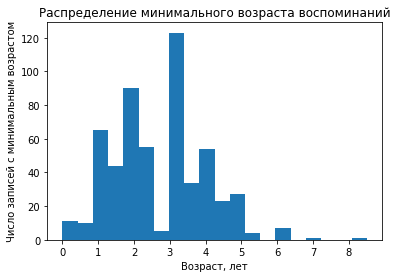

In [30]:
import matplotlib.pyplot as plt

plt.title('Распределение минимального возраста воспоминаний')
plt.xticks(range(0, 9))
plt.xlabel('Возраст, лет')
plt.ylabel('Число записей с минимальным возрастом')
plt.hist(age_df['min_age'], bins=20)
plt.show()

## Распределение числа воспоминаний в записях

## Распределение числа символов в записях

In [39]:
df = get_df()

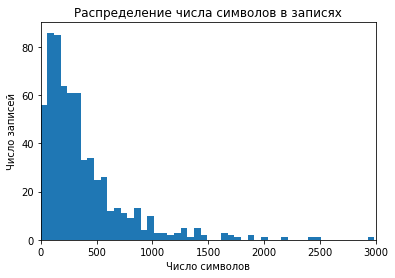

In [50]:
plt.xlim(left=0, right=3000)
plt.title('Распределение числа символов в записях')
plt.xlabel('Число символов')
plt.ylabel('Число записей')
plt.hist(df['Число символов'], bins=100)
plt.show()

## Среднее, минимальное и максимальное число символов, приходящееся на одно воспоминание

# Обработка текстуальной составляющей

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/index.html)

In [12]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

## В каком времени написаны воспоминания? Прошедшем или настоящем? То есть с взглядом из текущего времени или с эмоциональным погружением в ситуацию?

Для этого можно рассмотреть время глаголов воспоминаний. В грубом приближении достаточно ориентироваться на, глаголы какого времени преобладают – настоящего или прошедшего.

# Генерация latex для верстки pdf 